In [8]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import random
import torch

In [9]:
def parse_wet_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        
    documents = re.split(r'WARC/1.0', content)
    texts = []
    
    for doc in documents:
        if "WARC-Identified-Content-Language: eng" in doc:
            match = re.search(r'Content-Length: \d+\n\n(.*)', doc, re.DOTALL)
            if match:
                text = match.group(1)
                texts.append(text)
    
    return texts

In [10]:
def sample_random_prompts(texts, num_samples=25000, prompt_length=10):
    prompts = []
    for text in texts:
        tokens = text.split()
        
        if len(tokens) >= prompt_length:
            start_index = random.randint(0, len(tokens) - prompt_length)
            prompt = tokens[start_index:start_index + prompt_length]
            prompts.append(' '.join(prompt))
        
        if len(prompts) >= num_samples:
            break
    
    return prompts

In [11]:
def extract_emails(text):
    return re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text)

In [12]:
def num_times_email_leaked(emails, email):
    num_times = 0
    for mail in emails:
        if mail == email:
            num_times += 1
    return num_times

In [15]:
def generate_samples(wet_file_path, batch_size = 50, num_samples = 25000, max_length = 256):
    texts = parse_wet_file(wet_file_path)
    prompts = sample_random_prompts(texts, num_samples)
    tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
    folder_path = "models"
    checkpoints = [os.path.join(folder_path, ckpt) for ckpt in os.listdir(folder_path)]
    for ckpt in checkpoints:
        if ckpt == "models/120e3":
            continue
        print(f'processing : {ckpt}')
        model = AutoModelForCausalLM.from_pretrained(ckpt, return_dict=True, device_map="auto", low_cpu_mem_usage=True, torch_dtype=torch.float16)
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        os.makedirs("generations", exist_ok = True)
        os.makedirs("email_collection", exist_ok=True)
        
        checkpoint_name = ckpt.split('/')[-1]
        generation_name = f"generations/{checkpoint_name}.txt"
        df_name = f"email_collection/{checkpoint_name}_force_extract.csv"
        
        ckpt_summ = {}
        ckpt_summ['prompt'] = []
        ckpt_summ['email_leaked'] = []
        
        with open(generation_name, 'w') as file:
            for i in tqdm(range(0, len(prompts), batch_size), desc = "Extracting Emails"):
                batched_prompts = prompts[i:i+batch_size]
                inputs = tokenizer(batched_prompts, return_tensors = 'pt', truncation = True, max_length = 10).to(device)
                with torch.no_grad():
                    outputs = model.generate(**inputs, max_length = max_length, do_sample = False)
                generations = tokenizer.batch_decode(outputs, skip_special_tokens = True)
                for idx, generation in enumerate(generations):
                    file.write(f"{i+idx+1}. {generation}\n\n")
                for no in range(len(generations)):
                    emails_leaked = extract_emails(generations[no])
                    leakage_set = set(emails_leaked)
                    if 'kay.mann@enron.com' in leakage_set:
                        ckpt_summ['prompt'].append(batched_prompts[no])
                        num_times_leaked = num_times_email_leaked(emails_leaked, 'kay.mann@enron.com')
                        ckpt_summ['email_leaked'].append(num_times_leaked)
        ckpt_df = pd.DataFrame(ckpt_summ)
        ckpt_df.to_csv(df_name, index = False)
        
                            
        
        

In [16]:
generate_samples('crawl.wet', batch_size = 100, num_samples = 15000)

processing : models/100e1


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/100e2


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/100e3


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/10e1


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/10e2


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/10e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/110e3


Extracting Emails: 100%|██████████| 150/150 [03:40<00:00,  1.47s/it]


processing : models/20e1


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/20e2


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/20e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/30e1


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/30e2


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/30e3


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/40e1


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/40e2


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/40e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/50e1


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/50e2


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/50e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/60e1


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/60e2


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/60e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/70e1


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/70e2


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/70e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/80e1


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/80e2


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/80e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/90e1


Extracting Emails: 100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


processing : models/90e2


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


processing : models/90e3


Extracting Emails: 100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


In [29]:
csvfiles = os.listdir('email_collection')
csvfiles = [os.path.join('email_collection', file) for file in csvfiles]

plotter = {}

replotter = {}

for csv in csvfiles:
    if '.ipynb' in csv:
        continue
    print(csv)
    epoch_number = csv.split('.')[0]
    epoch_number = epoch_number.replace('email_collection/','')
    print(epoch_number)
    if 'force_extract' in epoch_number:
        continue
    step_num, epoch_num = epoch_number.split('e')
    perc = int(step_num) + (int(epoch_num) - 1)*100
    try:
        df = pd.read_csv(csv)
        leaked = list(df['email_leaked'])
        re_leaked = list(df['reextracted_email'])
        times_leaked = sum(leaked)
        re_times = sum(re_leaked)
        plotter[perc] = times_leaked
        replotter[perc] = re_times
    except Exception as e:
        print(e)
        continue

email_collection/100e1.csv
100e1
email_collection/100e1_force_extract.csv
100e1_force_extract
email_collection/100e2.csv
100e2
email_collection/100e2_force_extract.csv
100e2_force_extract
email_collection/100e3.csv
100e3
email_collection/100e3_force_extract.csv
100e3_force_extract
email_collection/10e1.csv
10e1
email_collection/10e1_force_extract.csv
10e1_force_extract
email_collection/10e2.csv
10e2
email_collection/10e2_force_extract.csv
10e2_force_extract
email_collection/10e3.csv
10e3
email_collection/10e3_force_extract.csv
10e3_force_extract
email_collection/110e3.csv
110e3
email_collection/110e3_force_extract.csv
110e3_force_extract
email_collection/120e3.csv
120e3
'email_leaked'
email_collection/20e1.csv
20e1
email_collection/20e1_force_extract.csv
20e1_force_extract
email_collection/20e2.csv
20e2
email_collection/20e2_force_extract.csv
20e2_force_extract
email_collection/20e3.csv
20e3
email_collection/20e3_force_extract.csv
20e3_force_extract
email_collection/30e1.csv
30e1
email

In [19]:
plotter = dict(sorted(plotter.items(), key = lambda x: x[0]))
replotter = dict(sorted(replotter.items(), key = lambda x: x[0]))

In [20]:
plotter

{10: 0,
 20: 0,
 30: 0,
 40: 0,
 50: 0,
 60: 30,
 70: 389,
 80: 941,
 90: 270,
 100: 1,
 110: 1877,
 120: 2762,
 130: 2053,
 140: 2382,
 150: 285,
 160: 1484,
 170: 1195,
 180: 322,
 190: 1151,
 200: 1364,
 210: 1982,
 220: 854,
 230: 526,
 240: 357,
 250: 1474,
 260: 1584,
 270: 2090,
 280: 2118,
 290: 2118,
 300: 2082,
 310: 2074}

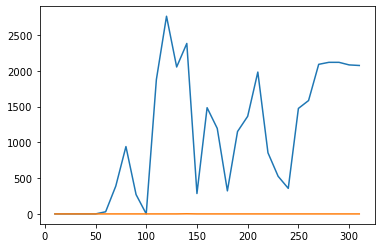

In [21]:
import matplotlib.pyplot as plt

plt.plot(plotter.keys(), plotter.values())
plt.plot(replotter.keys(), replotter.values())
plt.show()

In [28]:
csvfiles = os.listdir('email_collection')
csvfiles = [os.path.join('email_collection', file) for file in csvfiles]

new_plotter = {}

replotter = {}

for csv in csvfiles:
    if '.ipynb' in csv:
        continue
    print(csv)
    epoch_number = csv.split('.')[0]
    epoch_number = epoch_number.replace('email_collection/','')
    print(epoch_number)
    if 'force_extract' in epoch_number:
        epoch_number = epoch_number.replace('_force_extract','')
        step_num, epoch_num = epoch_number.split('e')
        perc = int(step_num) + (int(epoch_num) - 1)*100
    else:
        continue
    try:
        df = pd.read_csv(csv)
        leaked = list(df['email_leaked'])
        times_leaked = sum(leaked)
        new_plotter[perc] = times_leaked
    except Exception as e:
        print(e)
        continue

email_collection/100e1.csv
100e1
email_collection/100e1_force_extract.csv
100e1_force_extract
email_collection/100e2.csv
100e2
email_collection/100e2_force_extract.csv
100e2_force_extract
email_collection/100e3.csv
100e3
email_collection/100e3_force_extract.csv
100e3_force_extract
email_collection/10e1.csv
10e1
email_collection/10e1_force_extract.csv
10e1_force_extract
email_collection/10e2.csv
10e2
email_collection/10e2_force_extract.csv
10e2_force_extract
email_collection/10e3.csv
10e3
email_collection/10e3_force_extract.csv
10e3_force_extract
email_collection/110e3.csv
110e3
email_collection/110e3_force_extract.csv
110e3_force_extract
email_collection/120e3.csv
120e3
email_collection/20e1.csv
20e1
email_collection/20e1_force_extract.csv
20e1_force_extract
email_collection/20e2.csv
20e2
email_collection/20e2_force_extract.csv
20e2_force_extract
email_collection/20e3.csv
20e3
email_collection/20e3_force_extract.csv
20e3_force_extract
email_collection/30e1.csv
30e1
email_collection/30e

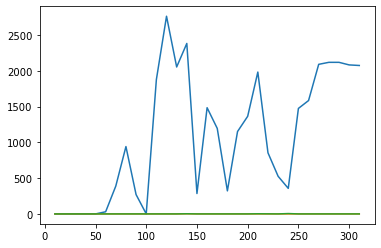

In [33]:
plotter = dict(sorted(plotter.items(), key = lambda x : x[0]))
new_plotter = dict(sorted(new_plotter.items(), key = lambda x: x[0]))
replotter = dict(sorted(replotter.items(), key = lambda x: x[0]))
plt.plot(plotter.keys(), plotter.values())
plt.plot(replotter.keys(), replotter.values())
plt.plot(new_plotter.keys(), new_plotter.values())
plt.show()